In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
df = pd.read_excel('kritik_saran.xlsx', sheet_name="Sheet1")


In [3]:
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# from sklearn.feature_extraction.text import TfidfVectorizer
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# # Terapkan stemming
# df['ULASAN'] = df['ULASAN'].apply(lambda x: stemmer.stem(str(x)))


In [4]:
# Mengubah tipe data kolom 'ULASAN' menjadi string untuk menghindari error
df['ULASAN'] = df['ULASAN'].astype(str)

In [5]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer

factory = StopWordRemoverFactory()
indonesian_stopwords = factory.get_stop_words()

# Langsung TF-IDF tanpa stemming
vectorizer = TfidfVectorizer(stop_words=indonesian_stopwords)
X_tfidf = vectorizer.fit_transform(df['ULASAN'])


In [6]:
# Hitung total TF-IDF score untuk setiap dokumen (ulasan)
tfidf_scores = X_tfidf.sum(axis=1)  # hasilnya matrix

# Ubah ke array 1D
df['TFIDF_Score'] = np.asarray(tfidf_scores).flatten()

# Hitung jumlah kata di setiap kalimat
df['Jumlah_Kata'] = df['ULASAN'].apply(lambda x: len(str(x).split()))

# Tandai relevan dan tidak relevan sesuai kriteria
df['Relevan'] = (df['TFIDF_Score'] > 1) & (df['Jumlah_Kata'] > 2)
df['Tidak_Relevan'] = (df['TFIDF_Score'] <= 1) & (df['Jumlah_Kata'] <= 2)

# Pisahkan data relevan dan tidak relevan
df_relevan = df[df['Relevan']]
df_tidak_relevan = df[df['Tidak_Relevan']]

# Cek hasilnya (opsional)
print(f"Jumlah data relevan: {len(df_relevan)}")
print(f"Jumlah data tidak relevan: {len(df_tidak_relevan)}")

Jumlah data relevan: 2308
Jumlah data tidak relevan: 134


In [7]:
df_relevan[['ULASAN', 'TFIDF_Score']].to_excel('ulasan_relevan.xlsx', index=False)
df_tidak_relevan[['ULASAN', 'TFIDF_Score']].to_excel('ulasan_tidak_relevan.xlsx', index=False)

In [8]:
df = pd.read_excel('ulasan_relevan.xlsx', sheet_name="Sheet1")


n_components=50, n_clusters=2, Silhouette=0.0243
n_components=50, n_clusters=3, Silhouette=0.0438
n_components=50, n_clusters=4, Silhouette=0.0548
n_components=50, n_clusters=5, Silhouette=0.0637
n_components=50, n_clusters=6, Silhouette=0.0464
n_components=50, n_clusters=7, Silhouette=0.0739
n_components=50, n_clusters=8, Silhouette=0.0793
n_components=100, n_clusters=2, Silhouette=0.0847
n_components=100, n_clusters=3, Silhouette=0.0682
n_components=100, n_clusters=4, Silhouette=0.0724
n_components=100, n_clusters=5, Silhouette=0.0732
n_components=100, n_clusters=6, Silhouette=0.0836
n_components=100, n_clusters=7, Silhouette=0.0673
n_components=100, n_clusters=8, Silhouette=0.0478
n_components=150, n_clusters=2, Silhouette=0.0560
n_components=150, n_clusters=3, Silhouette=0.0367
n_components=150, n_clusters=4, Silhouette=0.0395
n_components=150, n_clusters=5, Silhouette=0.0422
n_components=150, n_clusters=6, Silhouette=0.0310
n_components=150, n_clusters=7, Silhouette=0.0353
n_compo

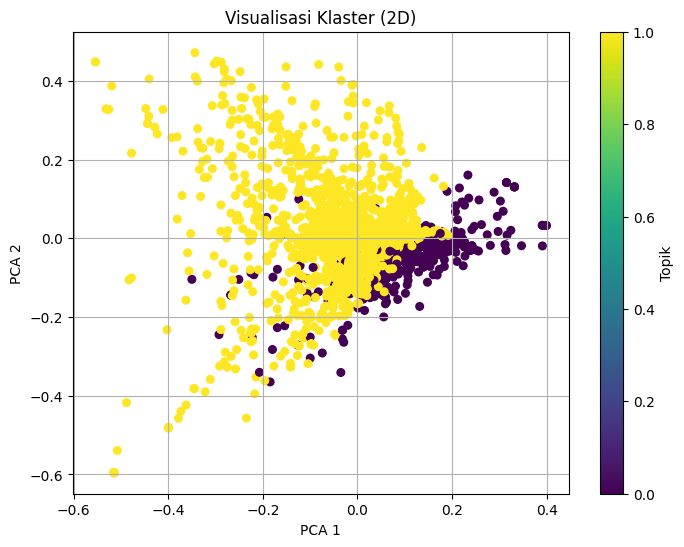

In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stopwords bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords_id = factory.get_stop_words()

# TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(stop_words=stopwords_id)
X_tfidf = vectorizer_tfidf.fit_transform(df['ULASAN'])

# CountVectorizer dan LDA
vectorizer_count = CountVectorizer(max_df=0.9, min_df=5, stop_words=stopwords_id)
X_counts = vectorizer_count.fit_transform(df['ULASAN'])
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(X_counts)

# Topik LDA ke df
topic_distribution = lda.transform(X_counts)
dominant_topic = np.argmax(topic_distribution, axis=1)
df['Topik_LDA'] = dominant_topic

# Cari kombinasi terbaik n_components dan n_clusters
n_components_list = [50, 100, 150, 200, 250]
n_clusters_list = range(2, 9)

best_score = -1
best_config = (None, None)

for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X_reduced = svd.fit_transform(X_tfidf)
    
    for k in n_clusters_list:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(X_reduced)
        score = silhouette_score(X_reduced, labels)
        print(f"n_components={n_components}, n_clusters={k}, Silhouette={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_config = (n_components, k)

print(f"\nBest combo: n_components={best_config[0]}, n_clusters={best_config[1]} with Silhouette={best_score:.4f}")

# Buat model dengan parameter terbaik
best_n_components, best_n_clusters = best_config
svd = TruncatedSVD(n_components=best_n_components, random_state=0)
X_reduced = svd.fit_transform(X_tfidf)

kmeans = KMeans(n_clusters=best_n_clusters, random_state=0)
df['Topik'] = kmeans.fit_predict(X_reduced)

# Fungsi top tfidf kata per cluster
def top_tfidf_words(docs, top_n=10):
    vec = TfidfVectorizer(stop_words=stopwords_id)
    X = vec.fit_transform(docs)
    mean_tfidf = np.asarray(X.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    return [vec.get_feature_names_out()[i] for i in top_indices]

for i in range(best_n_clusters):
    cluster_docs = df[df['Topik'] == i]['ULASAN']
    print(f"\nTop kata di Klaster {i}: {top_tfidf_words(cluster_docs)}")

# Visualisasi hasil klaster 2D
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['Topik'], cmap='viridis', s=30)
plt.title("Visualisasi Klaster (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Topik')
plt.grid(True)
plt.show()


In [10]:
# 1. Buat label yang bermakna untuk tiap topik
topic_labels = {
    0: "Kritik Dan Harapan",
    1: "Saran dan Pujian"
}

# 2. Map ke DataFrame
df['Topik_Label'] = df['Topik'].map(topic_labels)

# 3. Tampilkan hasil lengkap

pd.set_option('display.max_colwidth', None)
print(df[['ULASAN', 'Topik', 'Topik_Label']])
# Lihat contoh ulasan dari tiap topik
print(df[df['Topik'] == 0]['ULASAN'].sample(5))
print(df[df['Topik'] == 1]['ULASAN'].sample(5))


df[['ULASAN', 'Topik', 'Topik_Label']].to_excel("hasil_klaster_teks_asli.xlsx", index=False)


                                                                                                                                          ULASAN  \
0                                                                                                                            acnya kurang dingin   
1                                                                                  Semoga pelatihnya di perluas lagi lingkupnya di Kota Parepare   
2                                                                                                             lumayan dinginn dan lumayan bersih   
3                                                                                                                     Pencahayaan ruangan kurang   
4                                                         Untuk anak JGD kursi nya kekecilan, susah mouse bergerak selebihnya bagus. Terimakasih   
...                                                                                                             

NAIVE BAYES SEBAGAI PELATIHAN DAN PEMBUATAN MODEL NLP


In [11]:
df['ULASAN'] = df['ULASAN'].fillna('').astype(str)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Fitur dan label
X = df['ULASAN']
y = df['Topik_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords_id)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Prediksi
y_pred = nb.predict(X_test_tfidf)


In [12]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



📊 Classification Report:
                    precision    recall  f1-score   support

Kritik Dan Harapan       0.93      0.44      0.60        86
  Saran dan Pujian       0.89      0.99      0.94       376

          accuracy                           0.89       462
         macro avg       0.91      0.72      0.77       462
      weighted avg       0.89      0.89      0.87       462


🧮 Confusion Matrix:
[[ 38  48]
 [  3 373]]


In [13]:
new_texts = ["materi sangat mudah dipahami", "kursi keras dan ruang terlalu panas"]
new_vec = vectorizer.transform(new_texts)
predictions = nb.predict(new_vec)

for txt, label in zip(new_texts, predictions):
    print(f"\n📝 \"{txt}\" → 🔖 Predicted Topik: {label}")



📝 "materi sangat mudah dipahami" → 🔖 Predicted Topik: Saran dan Pujian

📝 "kursi keras dan ruang terlalu panas" → 🔖 Predicted Topik: Saran dan Pujian


In [14]:
import joblib

# Simpan model Naive Bayes
joblib.dump(nb, 'Model_NB.pkl')

# Simpan vectorizer TF-IDF
joblib.dump(vectorizer, 'Model_NB.pkl')


['Model_NB.pkl']